In [1]:
import numpy as np
from scipy.constants import m_e, pi
import math as m
from scipy.constants import elementary_charge as q
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy import linalg
from numba import njit, prange, float64, types, boolean, int32
from numba.typed import Dict
from scipy import integrate
from random import triangular
from numba.experimental import jitclass
from numba.extending import as_numba_type
from warnings import simplefilter
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
simplefilter('ignore', category=NumbaDeprecationWarning)
simplefilter('ignore', category=NumbaPendingDeprecationWarning)

spec1 = [
    ('x0', float64),
    ('y0', float64),
    ('xend', float64),
    ('yend', float64),
    ('width', float64),
    ('height', float64),
    ('angle', float64),
    ('potential', float64),
    ('x', float64[:]),
    ('y', float64[:]),
    ('name', types.string),
    ('pos0_part', float64[:]),
    ('is_emissive', boolean),
    ('energy_dist', boolean),
    ('endobj', boolean),
    ('result', boolean),
    ('union', boolean),
]

@jitclass(spec1)
class Quad_numba:
    def __init__(self, x0, y0, width, height, angle, potential = 0):
        self.x = np.array([x0, x0 + width, x0 + width, x0, x0])
        self.y = np.array([y0, y0 + width * np.tan(angle), y0 + width * np.tan(angle) + height, y0 + height, y0])
        self.x0 = x0
        self.y0 = y0
        self.xend = max(self.x)
        self.yend = max(self.y)
        self.potential = potential
        self.width = width
        self.height = height
        self.angle = angle
        self.name = 'Quad'
        self.is_emissive = False
        self.energy_dist = False
        self.endobj = False
        self.union = False
    
    def __eq__(self, __value) -> bool:
        return self.name == __value.__str__
    
    def __str__(self) -> str:
        return self.name

    def potential_mask(self, phi, dxdy_vec, bias):
        for j in range(int((self.x0 + bias)/ dxdy_vec[0]), int((self.xend + bias) / dxdy_vec[0]) + 1):
            for i in range(int((self.y0 + bias) / dxdy_vec[1]), int((self.yend + bias) / dxdy_vec[1]) + 1):
                if (self.intersect_mask_quad(bias, (j, i), dxdy_vec) and (i < phi.shape[0]) and (j < phi.shape[1])):
                    phi[i][j] = self.potential
        return phi
    
    def intersect_mask_quad(self, bias, pos0_part_ji, dxdy_vec):

        tmp_xend = self.xend
        tmp_x0 = self.x0
        tmp_yend = self.yend
        tmp_y0 = self.y0
        tmp_height = self.height

        self.xend = ((self.xend + bias) / dxdy_vec[0])
        self.x0 = ((self.x0 + bias) / dxdy_vec[0])
        self.yend = ((self.yend + bias) / dxdy_vec[1])
        self.y0 =  ((self.y0 + bias) / dxdy_vec[1])
        self.height = (self.height / dxdy_vec[1])

        result = self.intersect_mask_quad_xy(pos0_part_ji)

        self.xend = tmp_xend
        self.x0 = tmp_x0
        self.yend = tmp_yend
        self.y0 = tmp_y0
        self.height = tmp_height

        return result
    
    def intersect_mask_quad_xy(self, pos0_part):
        return ((pos0_part[1] >= np.tan(self.angle) * (pos0_part[0] - self.x0) + self.y0) \
        and (pos0_part[1] <= np.tan(self.angle) * (pos0_part[0] - self.x0) + (self.y0 + self.height)) \
        and (pos0_part[0] >= self.x0) and (pos0_part[0] <= self.xend))

spec2 = [
    ('x0', float64),
    ('y0', float64),
    ('xend', float64),
    ('yend', float64),
    ('width', float64),
    ('angle_left', float64),
    ('angle_right', float64),
    ('potential', float64),
    ('x', float64[:]),
    ('y', float64[:]),
    ('name', types.string),
    ('height', float64),
    ('pos0_part', float64[:]),
    ('is_emissive', boolean),
    ('energy_dist', boolean),
    ('endobj', boolean),
    ('result', boolean),
    ('union', boolean),
]

@jitclass(spec2)
class Triangle_numba:
    def __init__(self, x0, y0, width, angle_left, angle_right, potential = 0):
        self.height = width / (np.cos(angle_right) / np.sin(angle_right) + np.cos(angle_left) / np.sin(angle_left))
        self.x = np.array([x0, x0 + width, x0 + width - np.cos(angle_right) / np.sin(angle_right) * self.height, x0])
        self.y = np.array([y0, y0, y0 + self.height, y0])
        self.x0 = min(self.x)
        self.y0 = min(self.y)
        self.xend = max(self.x)
        self.yend = max(self.y)
        self.potential = potential
        self.angle_right = angle_right
        self.angle_left = angle_left
        self.name = 'Triangle'
        self.width = width
        self.is_emissive = False
        self.energy_dist = False
        self.endobj = False
        self.union = False

    def __eq__(self, __value) -> bool:
        return self.name == __value.__str__
    
    def __str__(self) -> str:
        return self.name

    def potential_mask(self, phi, dxdy_vec, bias):
        for j in range(int((self.x0 + bias)/ dxdy_vec[0]), int((self.xend + bias) / dxdy_vec[0]) + 1):
            for i in range(int((self.y0 + bias) / dxdy_vec[1]), int((self.yend + bias) / dxdy_vec[1]) + 1):
                if (self.intersect_mask_quad(bias, (j, i), dxdy_vec) and (i < phi.shape[0]) and (j < phi.shape[1])):
                    phi[i][j] = self.potential
        return phi

    def intersect_mask_quad(self, bias, pos0_part_ij, dxdy_vec):

        tmp_xend = self.xend
        tmp_x0 = self.x0
        tmp_yend = self.yend
        tmp_y0 = self.y0

        self.xend = ((self.xend + bias) / dxdy_vec[0])
        self.x0 = ((self.x0+ bias) / dxdy_vec[0])
        self.yend = ((self.yend + bias) / dxdy_vec[1])
        self.y0 =  ((self.y0 + bias) / dxdy_vec[1])

        result = self.intersect_mask_quad_xy(pos0_part_ij)

        self.xend = tmp_xend
        self.x0 = tmp_x0
        self.yend = tmp_yend
        self.y0 = tmp_y0

        return result

    def intersect_mask_quad_xy(self, pos0_part):
        if (abs(self.angle_left) == (pi / 2)) :
            if (self.angle_left < 0):

                return ((pos0_part[1] <= self.yend) \
                and (pos0_part[1] >= (np.tan(-self.angle_right) * (pos0_part[0] - self.xend) + self.yend)) \
                and (pos0_part[0] >= self.x0) and (pos0_part[0] <= self.xend))
            else:
                return ((pos0_part[1] >= self.y0) \
                and (pos0_part[1] <= (np.tan(pi - self.angle_right) * (pos0_part[0] - self.xend) + self.y0)) \
                and (pos0_part[0] >= self.x0) and (pos0_part[0] <= self.xend))
            
        elif (abs(self.angle_right) == (pi / 2)) :

            if (self.angle_right < 0):
                return ((pos0_part[1] >= (np.tan(self.angle_left) * (pos0_part[0] - self.x0) + self.yend)) \
                and (pos0_part[1] <= self.yend) \
                and (pos0_part[0] >= self.x0) and (pos0_part[0] <= self.xend))
            else:
                return ((pos0_part[1] <= (np.tan(self.angle_left) * (pos0_part[0] - self.x0) + self.y0)) \
                and (pos0_part[1] >= self.y0) \
                and (pos0_part[0] >= self.x0) and (pos0_part[0] <= self.xend))
            
        else:
            
            return ((pos0_part[1] <= (np.tan(self.angle_left) * (pos0_part[0] - self.x0) + self.y0)) \
            and (pos0_part[1] <= (np.tan(pi - self.angle_right) * (pos0_part[0] - self.xend) + self.y0)) \
            and (pos0_part[0] >= self.x0) and (pos0_part[0] <= self.xend))

spec3 = [
    ('x0', float64),
    ('y0', float64),
    ('xend', float64),
    ('yend', float64),
    ('width', float64),
    ('angle_left', float64),
    ('angle_right', float64),
    ('potential', float64),
    ('x', float64[:]),
    ('y', float64[:]),
    ('name', types.string),
    ('height', float64),
    ('pos0_part', float64[:]),
    ('is_emissive', boolean),
    ('height', float64),
    ('angle', float64),
    ('potential', float64),
    ('quad_obj', as_numba_type(Quad_numba)),
    ('triangle_obj', as_numba_type(Triangle_numba)),
    ('number_of_union_obj_in_obj_list', int32[:]),
    ('energy_dist', boolean),
    ('endobj', boolean),
    ('argobj', float64[:]),
    ('union', boolean),
]

@jitclass(spec3)
class InterfaceGeom:
    def __init__(self, name, argobj):
        if (name == "Quad"):
            quad_obj = Quad_numba(argobj[0], argobj[1], argobj[2], argobj[3], argobj[4], argobj[5])
            self.quad_obj = quad_obj
            self.potential = quad_obj.potential
            self.x0 = quad_obj.x0 
            self.y0 = quad_obj.y0
            self.x = quad_obj.x
            self.y = quad_obj.y
            self.xend = quad_obj.xend 
            self.yend = quad_obj.yend
            self.width = quad_obj.width
            self.height = quad_obj.height
            self.angle = quad_obj.angle
            self.is_emissive = quad_obj.is_emissive
            self.union = quad_obj.union
        else:
            triangle_obj = Triangle_numba(argobj[0], argobj[1], argobj[2], argobj[3], argobj[4], argobj[5])
            self.triangle_obj = triangle_obj
            self.potential = triangle_obj.potential
            self.x0 = triangle_obj.x0 
            self.y0 = triangle_obj.y0
            self.x = triangle_obj.x
            self.y = triangle_obj.y
            self.xend = triangle_obj.xend 
            self.yend = triangle_obj.yend
            self.width = triangle_obj.width 
            self.angle_left = triangle_obj.angle_left 
            self.angle_right = triangle_obj.angle_right
            self.union = triangle_obj.union
            self.is_emissive = triangle_obj.is_emissive
            self.height = triangle_obj.width / (np.cos(triangle_obj.angle_right) / np.sin(triangle_obj.angle_right) \
                                                + np.cos(triangle_obj.angle_left) / np.sin(triangle_obj.angle_left))

        self.energy_dist = False
        self.endobj = False
        self.name = name

    @staticmethod
    def createTriangle(x0, y0, width, angle_left, angle_right, potential = 0):
        name = 'Triangle'
        argobj = [x0, y0, width, angle_left, angle_right, potential]
        return InterfaceGeom(name, argobj)

    @staticmethod
    def createQuad(x0, y0, width, height, angle, potential = 0):
        name = 'Quad'
        argobj = [x0, y0, width, height, angle, potential]
        return InterfaceGeom(name, argobj)
    
    def potential_mask(self, phi, dxdy_vec, bias):
        if ((self.name == "Quad")):
            self.quad_obj.potential = self.potential
            return self.quad_obj.potential_mask(phi, dxdy_vec, bias)
        else:
            self.triangle_obj.potential = self.potential
            return self.triangle_obj.potential_mask(phi, dxdy_vec, bias)

    def intersect_mask_quad(self, bias, pos0_part_ij, dxdy_vec):
        if ((self.name == "Quad")):
            return self.quad_obj.intersect_mask_quad(bias, pos0_part_ij, dxdy_vec)
        else:
            return self.triangle_obj.intersect_mask_quad(bias, pos0_part_ij, dxdy_vec)
    
    def intersect_mask_quad_xy(self, pos0_part):
        if ((self.name == "Quad")):
            return self.quad_obj.intersect_mask_quad_xy(pos0_part)
        else:
            return self.triangle_obj.intersect_mask_quad_xy(pos0_part)
    
    def SetUnionList(self, number_of_union_obj_in_obj_list):
        self.number_of_union_obj_in_obj_list = number_of_union_obj_in_obj_list
        self.union = True
    
    def GetUnionList(self):
        return self.number_of_union_obj_in_obj_list
    
    def __eq__(self, __value) -> bool:
        return self.name == __value.__str__
    
    def __str__(self) -> str:
        return self.name

In [2]:
x_points = 100
discretization = 'Linear'
points_on_object_edge = 100
point_for_figure = 30

bias = 80e-6
energy1 = 0.01
vel_x1 = 0
vel_y1 = -1
dt = 0.3e-12
n_step = 150
angle = 0.1

vel1 = m.sqrt(2 * q * energy1 / m_e)
vel0_part1 = np.array([vel_x1 * vel1, vel_y1 * vel1])
time_arr = np.arange(0, n_step * dt, dt)

width_cathode2 = 5e-6
height_control2 = 2e-6
cathode_control_gap = 5e-6
electrodes_distance = 35e-6
bar_el_dinode_displacement_y = 7e-6
bar_el_dinode_displacement_x = 10e-6
delta_V = 500
dinode_V0 = 250
control_potenitial = 50
cathode_potential = 0
downer_dinode_control_displacement_x = 20e-6
downer_dinode_control_displacement_y = 35e-6
bar_el_anode_displacement_x = 15.5e-6
displacement_dinodes_x = -2.5e-6
displacement_dinodes_y = 26e-6
electrodes_height = 60e-6
dinode_width = 30e-6
dinode_height = 36e-6
control_needle_width = 20e-6 
anode_y_displacement = -electrodes_height / 2 + 4e-6
bar_el_height = 60e-6

part_share_arr = [0.1]
energies = [0.0]
particle_counter= []
particle_counter.extend([0] * len(time_arr)) 

control1 = InterfaceGeom.createQuad(0, 0, 140e-6, electrodes_height, 0)
control_needle = InterfaceGeom.createQuad(control1.xend, control1.yend - height_control2, control_needle_width, height_control2, angle)
height_cathode2 = electrodes_distance - control_needle.width * np.tan(angle) - cathode_control_gap / np.cos(angle)
cathode1 = InterfaceGeom.createQuad(0, control1.yend + electrodes_distance, control1.xend + control_needle.width, 48e-6, 0)
cathode_needle = InterfaceGeom.createQuad(cathode1.xend - width_cathode2, cathode1.y0 - height_cathode2, width_cathode2, height_cathode2, 0)
dinode1 = InterfaceGeom.createQuad(control1.xend + downer_dinode_control_displacement_x, control_needle.y0 - downer_dinode_control_displacement_y - dinode_height, dinode_width, dinode_height, 0)
dinode2 = InterfaceGeom.createQuad(dinode1.xend + displacement_dinodes_x, displacement_dinodes_y + dinode1.height, dinode1.width, dinode1.height, 0)
bar1 = InterfaceGeom.createQuad(dinode1.xend + bar_el_dinode_displacement_x, dinode1.yend - bar_el_height - bar_el_dinode_displacement_y, 5e-6, bar_el_height, 0)
bar0 = InterfaceGeom.createQuad(dinode2.x0 - bar1.width - bar_el_dinode_displacement_x, dinode2.y0 + bar_el_dinode_displacement_y, bar1.width, bar1.height, 0)
anode = InterfaceGeom.createQuad(bar1.xend + bar_el_anode_displacement_x, anode_y_displacement, 100e-6, electrodes_height, 0)

dinode1_triangle = InterfaceGeom.createTriangle(dinode1.x0, dinode1.yend, dinode1.width, pi / 2, angle, 0)
dinode2_triangle = InterfaceGeom.createTriangle(dinode2.x0, dinode2.y0, dinode2.width, -pi / 2, - angle, 0)
cathode_triangle = InterfaceGeom.createTriangle(cathode_needle.x0, cathode_needle.y0, width_cathode2, -pi / 2, -angle, 0)

x_pos1  = cathode_needle.xend - width_cathode2 / 2
y_pos1 = cathode_triangle.y0
pos0_part1 = np.array([x_pos1, y_pos1])

cathode1.potential = cathode_potential
dinode1.potential = dinode_V0
control1.potential = control_potenitial
cathode_needle.potential = cathode1.potential
cathode_triangle.potential = cathode1.potential
dinode2.potential = dinode1.potential + delta_V
control_needle.potential = control1.potential
anode.potential = dinode1.potential + 3 * delta_V 
bar1.potential = dinode1.potential
bar0.potential = cathode1.potential
dinode1_triangle.potential = dinode1.potential
dinode2_triangle.potential = dinode2.potential

dinode1_triangle.is_emissive = True
dinode2_triangle.is_emissive = True
dinode1.is_emissive = True
dinode2.is_emissive = True

anode.energy_dist = True
anode.endobj = True

objects =  [cathode1, cathode_needle, control1, control_needle, dinode1,\
        dinode2, anode, bar1, bar0, dinode1_triangle, dinode2_triangle, cathode_triangle]

objects_dict = dict(zip(range(len(objects)), objects))

dinode1_triangle.SetUnionList(np.array([4, 9], dtype = np.int32))
dinode2_triangle.SetUnionList(np.array([5, 10], dtype = np.int32))
dinode1.SetUnionList(np.array([4, 9], dtype = np.int32))
dinode2.SetUnionList(np.array([5, 10], dtype = np.int32))
anode.SetUnionList(np.array([6], dtype = np.int32))

elements_index_without_computing = np.array([3], dtype = np.int32)

In [3]:
def mesh(bias, x_points, quads):
    max_xend = max(quads, key = lambda x: x.xend).xend
    max_yend = max(quads, key = lambda x: x.yend).yend
    aspect_ratio = (max_yend + 2 * bias) / (max_xend + 2 * bias)
    x_array = np.linspace(-bias, max_xend + bias, x_points)
    y_array = np.linspace(-bias, max_yend + bias, int(aspect_ratio * x_points))
    y_array = list(reversed(y_array))
    xy_vec = np.meshgrid(x_array, y_array)
    dxdy_vec = ((max_xend + 2 * bias)/ len(x_array), (max_yend + 2 * bias) / len(y_array))
    return dxdy_vec, xy_vec, x_array, y_array

In [4]:
def union_obj(quads):
    for quad in quads:
        plt.plot(np.array(quad.x) * 1e6, np.array(quad.y) * 1e6, color = 'black')

In [5]:
def GetPointFromOjbect(quads):
    points = []
    for quad in quads:
        points_on_y_edge = points_on_object_edge
        points_on_x_edge = points_on_object_edge

        if (abs(quad.x0 - quad.xend) <= 10e-6):
            points_on_x_edge = 2
        if (abs(quad.y0 - quad.yend) <= 3e-6):
            points_on_y_edge = 2

        point = [np.linspace(quad.x0, quad.x0 + quad.width, points_on_x_edge),
                 np.linspace(quad.y0, quad.y0 + quad.height, points_on_y_edge)]
        
        match quad.name:
            case "Quad":
                for x in point[0]:
                    points.append((x, quad.y0 + m.tan(quad.angle) * (x - quad.x0)))
                    points.append((x, quad.y0 + quad.height + m.tan(quad.angle) * (x - quad.x0)))   
                    
                for y in point[1]:
                        points.append((quad.x0, y))
                        if(x == 0):
                            points.append((quad.x0 + quad.width, y))
                if(x != 0):
                    for y in np.linspace(quad.y0 + quad.width * np.tan(quad.angle), quad.y0 + quad.width * np.tan(quad.angle) + quad.height, points_on_object_edge):
                        points.append((quad.x0 + quad.width, y))
            case "Triangle":
                for x in point[0]:
                    if ((quad.angle_left > 0) and (quad.angle_right > 0)):
                        points.append((x, quad.y0))
                    else:
                        points.append((x, quad.y0 - m.tan(quad.angle_right) * (x - quad.x0)))
                for y in point[1]:
                    if ((quad.angle_left > 0) and (quad.angle_right > 0)):
                        points.append((quad.x0 + quad.width - np.cos(quad.angle_right) / np.sin(quad.angle_right) * (y - quad.y0), y))
                for x in np.linspace(quad.x0, quad.x0 + quad.width - np.cos(quad.angle_right) 
                                     / np.sin(quad.angle_right) * quad.height, points_on_object_edge):
                    points.append((x, quad.y0 + np.tan(quad.angle_left) * (x - quad.x0)))
            case _:
                raise Exception("The geometry name object is wrong")
    return points

In [6]:
dxdy_vec, xy_vec, x_array, y_array = mesh(bias, x_points, objects)

Nodes = []

for j in y_array:
    for i in x_array:
        Nodes.append((i, j))

quad_points = list(set(GetPointFromOjbect(objects)))
for quad_point in quad_points:
    Nodes.append(quad_point)

points = np.array(Nodes)
tri = Delaunay(points)
number_of_points_of_elements = tri.simplices

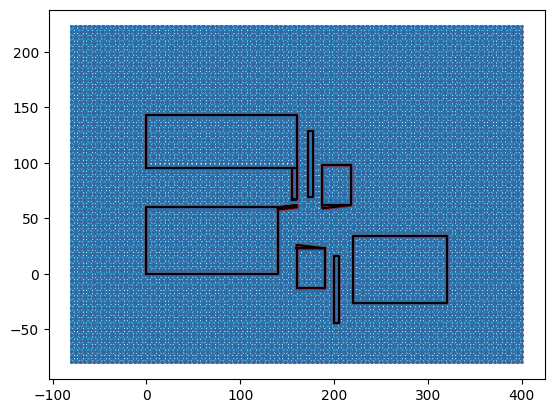

In [7]:
plt.rcParams['lines.markersize'] = 0.2
plt.triplot(points[:, 0] * 1e6, points[:, 1] * 1e6, tri.simplices)
plt.plot(points[:, 0] * 1e6, points[:, 1] * 1e6, 'ro')
union_obj(objects)
plt.show()

In [8]:
@njit()
def adj_list_jit_gen(points, number_of_points_of_elements):
    adj_list = Dict.empty(
            key_type=types.int64,
            value_type=types.int64[:],
        )
    for point_ind, _ in enumerate(points):  
        adj_list[point_ind] = np.array([-1], dtype=np.int64) 
        for tri_ind, triangle in enumerate(number_of_points_of_elements):
            if point_ind in triangle:
                adj_list[point_ind] = np.append(adj_list[point_ind], tri_ind)
        adj_list[point_ind] = np.delete(adj_list[point_ind], 0)

# adj_list_jit_gen(points, number_of_points_of_elements)

In [9]:
@njit()
def find_сommon_elements(node1, node2):
    results = -np.ones((len(number_of_points_of_elements), 3))
    for element, number_of_element in zip(number_of_points_of_elements, range(len(number_of_points_of_elements))):
        if((node1 in element) and (node2 in element)):
            index_node1_in_element = list(element).index(node1)
            index_node2_in_element = list(element).index(node2)
            results[number_of_element][0] = number_of_element
            results[number_of_element][1] = index_node1_in_element
            results[number_of_element][2] = index_node2_in_element
    return results

In [10]:
@njit(parallel=True)
def global_matrix_of_stiffness_computator(points, number_of_points_of_elements):
    global_matrix_of_stiffness = np.zeros((len(points), len(points)), dtype=float)

    adj_list = Dict.empty(
            key_type=types.int64,
            value_type=types.int64[:],
        )
    for point_ind, _ in enumerate(points):  
        adj_list[point_ind] = np.array([-1], dtype=np.int64) 
        for tri_ind, triangle in enumerate(number_of_points_of_elements):
            if point_ind in triangle:
                adj_list[point_ind] = np.append(adj_list[point_ind], tri_ind)
        adj_list[point_ind] = np.delete(adj_list[point_ind], 0)
    
    for i in prange(len(points)):
        for j in prange(len(points)):
            # results = find_сommon_elements(i, j)
            results = set(adj_list[i]) & set(adj_list[j])
            for result in results:
                # if(-1 not in result):
                    # element = result[0]
                    # i_index = result[1]
                    # j_index = result[2]

                    element = result
                    i_index = list(number_of_points_of_elements[result]).index(i)
                    j_index = list(number_of_points_of_elements[result]).index(j)

                    triangle_points = points[number_of_points_of_elements[int(element)]]
                    triangle_area = triangle_points[1][0] * triangle_points[2][1] - triangle_points[2][0] * triangle_points[1][1] \
                                    - triangle_points[0][0] * triangle_points[2][1] + triangle_points[2][0] * triangle_points[0][1] \
                                    + triangle_points[0][0] * triangle_points[1][1] - triangle_points[1][0] * triangle_points[0][1]
                    coef_point1 = [triangle_points[1][1] - triangle_points[2][1], triangle_points[2][0] - triangle_points[1][0]]
                    coef_point2 = [triangle_points[2][1] - triangle_points[0][1], triangle_points[0][0] - triangle_points[2][0]]
                    coef_point3 = [triangle_points[0][1] - triangle_points[1][1], triangle_points[1][0] - triangle_points[0][0]]
                    coef_points = [coef_point1, coef_point2, coef_point3]
                    global_matrix_of_stiffness[int(i), int(j)] += (float(coef_points[int(i_index)][0]) * float(coef_points[int(j_index)][0]) \
                                                                + float(coef_points[int(i_index)][1]) * float(coef_points[int(j_index)][1])) / (2 * triangle_area)
    return global_matrix_of_stiffness

global_matrix_of_stiffness = global_matrix_of_stiffness_computator(points, number_of_points_of_elements)

C:\Users\Я -- Машина\AppData\Local\Temp\ipykernel_4448\2907529971.py:19: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  results = set(adj_list[i]) & set(adj_list[j])


In [11]:
@njit(parallel=True)
def global_matrix_boundary_condition(points, global_matrix_of_stiffness, objects):
    forces = np.zeros((len(points), 1))
    new_forces = np.zeros((len(points), 1))

    for point, i in zip(points, range(len(points))):
        for obj in objects:
            if obj.intersect_mask_quad_xy(point):
                forces[i] = obj.potential

    new_forces = np.dot(global_matrix_of_stiffness, forces)
    forces = -1 * new_forces

    for point, i in zip(points, range(len(points))):
        for obj in objects:
            if obj.intersect_mask_quad_xy(point):
                forces[i] = obj.potential

    for i in prange(len(points)):
        for obj in objects:
            if obj.intersect_mask_quad_xy(points[i]):
                for j in prange(len(points)):
                    if (i != j):
                        global_matrix_of_stiffness[j, i] = 0
                        global_matrix_of_stiffness[i, j] = 0
                    else:
                        global_matrix_of_stiffness[i, i] = 1
    potentials_array = np.zeros((len(points), 1))
    potentials_array = np.linalg.solve(global_matrix_of_stiffness, forces)
    return potentials_array

potentials_array = global_matrix_boundary_condition(points, global_matrix_of_stiffness, objects)

In [12]:
@njit()
def is_point_inside_triangle(triangle_p1, triangle_p2, triangle_p3, find_point):

    d1 = (triangle_p1[0] - find_point[0]) * (triangle_p2[1] - triangle_p1[1]) - (triangle_p2[0] - triangle_p1[0]) * (triangle_p1[1] - find_point[1])
    d2 = (triangle_p2[0] - find_point[0]) * (triangle_p3[1] - triangle_p2[1]) - (triangle_p3[0] - triangle_p2[0]) * (triangle_p2[1] - find_point[1])
    d3 = (triangle_p3[0] - find_point[0]) * (triangle_p1[1] - triangle_p3[1]) - (triangle_p1[0] - triangle_p3[0]) * (triangle_p3[1] - find_point[1])

    has_neg = ((d1 <= 0) and (d2 <= 0) and (d3 <= 0))
    has_pos = ((d1 >= 0) and (d2 >= 0) and (d3 >= 0))

    return (has_neg or has_pos)

In [13]:
@njit()
def potentials_func(x, y):
    for element, point_numbers_of_elements in enumerate(number_of_points_of_elements):
        p1 = points[int(point_numbers_of_elements[0])]
        p2 = points[int(point_numbers_of_elements[1])]
        p3 = points[int(point_numbers_of_elements[2])]
        find_point = [x, y]
        if (is_point_inside_triangle(p1, p2, p3, find_point)):
            triangle_points = points[number_of_points_of_elements[int(element)]]
            
            triangle_area = triangle_points[1][0] * triangle_points[2][1] - triangle_points[2][0] * triangle_points[1][1] \
                            - triangle_points[0][0] * triangle_points[2][1] + triangle_points[2][0] * triangle_points[0][1] \
                            + triangle_points[0][0] * triangle_points[1][1] - triangle_points[1][0] * triangle_points[0][1]

            coef_point1 = [(triangle_points[1][0] * triangle_points[2][1] - triangle_points[2][0] * triangle_points[1][1]) / triangle_area,
                        (triangle_points[1][1] - triangle_points[2][1]) / triangle_area, 
                        (triangle_points[2][0] - triangle_points[1][0]) / triangle_area]
            
            coef_point2 = [(triangle_points[2][0] * triangle_points[0][1] - triangle_points[0][0] * triangle_points[2][1]) / triangle_area,
                        (triangle_points[2][1] - triangle_points[0][1]) / triangle_area, 
                        (triangle_points[0][0] - triangle_points[2][0]) / triangle_area]
            
            coef_point3 = [(triangle_points[0][0] * triangle_points[1][1] - triangle_points[1][0] * triangle_points[0][1]) / triangle_area,
                        (triangle_points[0][1] - triangle_points[1][1]) / triangle_area, 
                        (triangle_points[1][0] - triangle_points[0][0]) / triangle_area]
            
            Shapefunction1 = coef_point1[0] + coef_point1[1] * x + coef_point1[2] * y
            Shapefunction2 = coef_point2[0] + coef_point2[1] * x + coef_point2[2] * y
            Shapefunction3 = coef_point3[0] + coef_point3[1] * x + coef_point3[2] * y
        
            return Shapefunction1 * potentials_array[number_of_points_of_elements[int(element)][0]] \
                    + Shapefunction2 * potentials_array[number_of_points_of_elements[int(element)][1]] \
                    + Shapefunction3 * potentials_array[number_of_points_of_elements[int(element)][2]] 

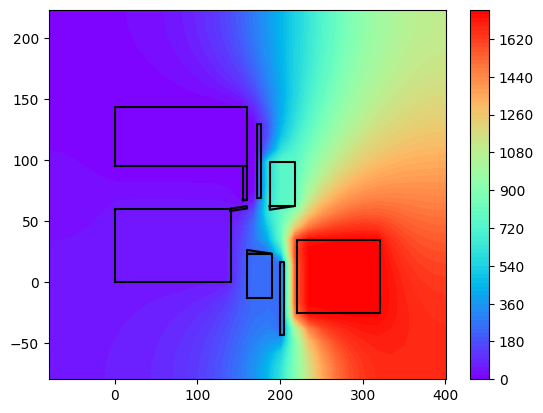

In [21]:
x_array = np.linspace(-bias, max(x_array), point_for_figure)
y_array = np.linspace(-bias, max(y_array), point_for_figure)
xy_vec = np.meshgrid(x_array, y_array)

@njit(parallel=True)
def contour_potential():
    potentials_matrix = np.zeros((len(y_array), len(x_array)))
    for i in prange(len(y_array)):
        for j in prange(len(x_array)):
            potentials_matrix[i, j] = ((potentials_func(x_array[j], y_array[i]))[0])
    return potentials_matrix

potentials_matrix = contour_potential()
       
union_obj(objects)
cs = plt.contourf(xy_vec[0] * 1e6, xy_vec[1] * 1e6, potentials_matrix, 100, cmap = 'rainbow')
plt.colorbar(cs)
plt.show()

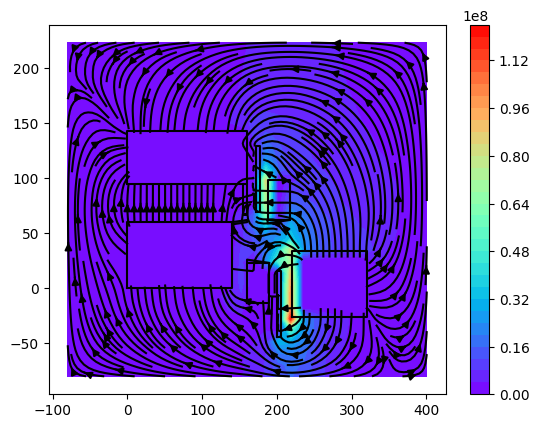

In [15]:
@njit()
def electric_field_x_func(x, y):
    for element, point_numbers_of_elements in enumerate(number_of_points_of_elements):
        
        p1 = points[int(point_numbers_of_elements[0])]
        p2 = points[int(point_numbers_of_elements[1])]
        p3 = points[int(point_numbers_of_elements[2])]
        find_point = [x, y]
        if (is_point_inside_triangle(p1, p2, p3, find_point)):
            triangle_points = points[number_of_points_of_elements[int(element)]]
            
            triangle_area = triangle_points[1][0] * triangle_points[2][1] - triangle_points[2][0] * triangle_points[1][1] \
                            - triangle_points[0][0] * triangle_points[2][1] + triangle_points[2][0] * triangle_points[0][1] \
                            + triangle_points[0][0] * triangle_points[1][1] - triangle_points[1][0] * triangle_points[0][1]

            coef_point1 = [(triangle_points[1][0] * triangle_points[2][1] - triangle_points[2][0] * triangle_points[1][1]) / triangle_area,
                        (triangle_points[1][1] - triangle_points[2][1]) / triangle_area, 
                        (triangle_points[2][0] - triangle_points[1][0]) / triangle_area]
            
            coef_point2 = [(triangle_points[2][0] * triangle_points[0][1] - triangle_points[0][0] * triangle_points[2][1]) / triangle_area,
                        (triangle_points[2][1] - triangle_points[0][1]) / triangle_area, 
                        (triangle_points[0][0] - triangle_points[2][0]) / triangle_area]
            
            coef_point3 = [(triangle_points[0][0] * triangle_points[1][1] - triangle_points[1][0] * triangle_points[0][1]) / triangle_area,
                        (triangle_points[0][1] - triangle_points[1][1]) / triangle_area, 
                        (triangle_points[1][0] - triangle_points[0][0]) / triangle_area]
            
            Shapefunction1 = -1 * coef_point1[1]
            Shapefunction2 = -1 * coef_point2[1]
            Shapefunction3 = -1 * coef_point3[1]
        
            return Shapefunction1 * potentials_array[number_of_points_of_elements[int(element)][0]] \
                    + Shapefunction2 * potentials_array[number_of_points_of_elements[int(element)][1]] \
                    + Shapefunction3 * potentials_array[number_of_points_of_elements[int(element)][2]]

@njit()
def electric_field_y_func(x, y):
    for element, point_numbers_of_elements in enumerate(number_of_points_of_elements):
        
        p1 = points[int(point_numbers_of_elements[0])]
        p2 = points[int(point_numbers_of_elements[1])]
        p3 = points[int(point_numbers_of_elements[2])]
        find_point = [x, y]
        if (is_point_inside_triangle(p1, p2, p3, find_point)):
            triangle_points = points[number_of_points_of_elements[int(element)]]
            
            triangle_area = triangle_points[1][0] * triangle_points[2][1] - triangle_points[2][0] * triangle_points[1][1] \
                            - triangle_points[0][0] * triangle_points[2][1] + triangle_points[2][0] * triangle_points[0][1] \
                            + triangle_points[0][0] * triangle_points[1][1] - triangle_points[1][0] * triangle_points[0][1]

            coef_point1 = [(triangle_points[1][0] * triangle_points[2][1] - triangle_points[2][0] * triangle_points[1][1]) / triangle_area,
                        (triangle_points[1][1] - triangle_points[2][1]) / triangle_area, 
                        (triangle_points[2][0] - triangle_points[1][0]) / triangle_area]
            
            coef_point2 = [(triangle_points[2][0] * triangle_points[0][1] - triangle_points[0][0] * triangle_points[2][1]) / triangle_area,
                        (triangle_points[2][1] - triangle_points[0][1]) / triangle_area, 
                        (triangle_points[0][0] - triangle_points[2][0]) / triangle_area]
            
            coef_point3 = [(triangle_points[0][0] * triangle_points[1][1] - triangle_points[1][0] * triangle_points[0][1]) / triangle_area,
                        (triangle_points[0][1] - triangle_points[1][1]) / triangle_area, 
                        (triangle_points[1][0] - triangle_points[0][0]) / triangle_area]
            
            Shapefunction1 = -1 * coef_point1[2]
            Shapefunction2 = -1 * coef_point2[2]
            Shapefunction3 = -1 * coef_point3[2]
        
            return Shapefunction1 * potentials_array[number_of_points_of_elements[int(element)][0]] \
                    + Shapefunction2 * potentials_array[number_of_points_of_elements[int(element)][1]] \
                    + Shapefunction3 * potentials_array[number_of_points_of_elements[int(element)][2]]

@njit(parallel=True)
def contour_potential():
    E_module = np.zeros((len(y_array), len(x_array)))
    E_matrix_y = np.zeros((len(y_array), len(x_array)))
    E_matrix_x = np.zeros((len(y_array), len(x_array)))
    for i in prange(len(y_array)):
        for j in prange(len(x_array)):
            E_matrix_x[i, j] = ((electric_field_x_func(x_array[j], y_array[i]))[0])
            E_matrix_y[i, j] = ((electric_field_y_func(x_array[j], y_array[i]))[0])
            E_module[i, j] = m.sqrt(E_matrix_x[i, j] * E_matrix_x[i, j] + E_matrix_y[i, j] * E_matrix_y[i, j])
    return E_matrix_x, E_matrix_y, E_module

E_matrix_x, E_matrix_y, E_module = contour_potential()

E_field = plt.contourf(xy_vec[0] * 1e6, xy_vec[1] * 1e6, E_module, 30, cmap = 'rainbow')
plt.streamplot(xy_vec[0] * 1e6, xy_vec[1] * 1e6, E_matrix_x, E_matrix_y, color = 'black', density = 2.0)
plt.colorbar(E_field)
union_obj(objects)
plt.show()

In [16]:
@njit()
def traj(bias, pos_part, time_arr, dt, dxdy_vec, vel0_part, objects, part_share_arr, particle_counter, energies, elements_index_without_computing):
    result = [0.0]
    old_vel_x = vel0_part[0]
    old_vel_y = vel0_part[1]
    for t in time_arr:
        if (x_array.min() <= pos_part[0] <= x_array.max()) and (y_array.min() <= pos_part[1] <= y_array.max()):
            j = int(abs(pos_part[0] + bias) / dxdy_vec[0])
            i = int(abs(pos_part[1] + bias) / dxdy_vec[1])

            result.append(pos_part[0])
            result.append(pos_part[1])
            
            flag_for_elements_index_without_computing = False

            for index_obj, obj in enumerate(objects):

                for index_of_array in elements_index_without_computing:
                    if (int(index_of_array) == int(index_obj)):
                        flag_for_elements_index_without_computing = True
                        continue

                if (flag_for_elements_index_without_computing):
                    flag_for_elements_index_without_computing = False
                    continue
                
                if (obj.intersect_mask_quad_xy(pos_part)):

                    pos_part = collision(result, obj, objects)
                    
                    if (int(pos_part[1]) != -101):
                        result[-1] = pos_part[1]
                        result[-2] = pos_part[0]
                    else:
                        result.append(-1.0)
                        return

                    if (not list(result)) :
                        result.append(pos_part[0])
                        result.append(pos_part[1])

                    if(obj.energy_dist):
                        part_energy = m_e * (old_vel_x ** 2 + old_vel_y ** 2) / (2 * q)
                        energies.append(part_energy)

                    if(obj.endobj):
                        result.append(-1.0)
                        for i, element in enumerate(result):
                            if (i > 0):
                                part_share_arr.append(element)

                        particle_counter[np.where(time_arr == t)[0][0]] += 1
                        return
                    
                    if (obj.is_emissive):
                        vel_xy = np.array([old_vel_x, old_vel_y])
                        intersect_emission(vel_xy, bias, pos_part, time_arr, dt, dxdy_vec, vel0_part, objects, part_share_arr, 
                                           particle_counter, obj, energies, elements_index_without_computing)

                    result.append(-1.0)
                    for i, element in enumerate(result):
                        if (i > 0):
                            part_share_arr.append(element)
                    return

            old_vel_x += -1 * q * ((electric_field_x_func(pos_part[0], pos_part[1]))[0]) * dt / m_e
            old_vel_y += -1 * q * ((electric_field_y_func(pos_part[0], pos_part[1]))[0]) * dt / m_e

            pos_part[0] += old_vel_x * dt
            pos_part[1] += old_vel_y * dt
        else:
            break

    result.append(-1.0)
    for i, element in enumerate(result):
        if (i > 0):
            part_share_arr.append(element)

@njit()
def intersect_emission(vel_xy, bias, pos0_part, time_arr, dt, dxdy_vec, vel0_part, objects, part_share_arr, 
                       particle_counter, obj_emission, energies, elements_index_without_computing):
    
    energy = m_e * (vel_xy[0] ** 2 + vel_xy[1] ** 2) / 2
    pair_formation_energy = 10
    part_energy = energy / q
    n_sec = part_energy / pair_formation_energy
    vel_sec = 5.5e5
    l_new_pos = 1e-8
    tmp = pos0_part
    for _ in range(int(n_sec)):
        alpha = alpha_compute(pos0_part, obj_emission)
        angle = angle_compute(vel_xy, alpha)
        pos0_part = [pos0_part[0] + l_new_pos * np.cos(angle), pos0_part[1] + l_new_pos * np.sin(angle)]
        vel0_part = [vel_sec * np.cos(angle), vel_sec * np.sin(angle)]
        traj(bias, pos0_part, time_arr, dt, dxdy_vec, vel0_part, objects, 
             part_share_arr, particle_counter, energies, elements_index_without_computing)

        pos0_part = tmp

@njit()
def angle_compute(vel_xy, alpha):
    if ((alpha != 0) and (vel_xy[1] > 0)):
        return triangular(alpha - pi, alpha)
    elif((vel_xy[0] > 0) and (alpha != 0)):
        return triangular(alpha, pi + alpha)
    elif((vel_xy[1] < 0) and (alpha == 0)):
        return triangular(alpha, pi + alpha)
    elif((vel_xy[0] < 0) and (alpha != 0)):
        return triangular(alpha - pi, alpha)
    elif((vel_xy[1] > 0) and (alpha == 0)):
        return triangular(alpha - pi, alpha)

@njit()
def alpha_compute(pos_part, quad):
    coord = []
    norm = []
 
    for x, y in zip(quad.x, quad.y):
        coord.append([x, y])

    for i in range(len(coord) - 1):
        a = np.sqrt((pos_part[0] - coord[i + 1][0]) ** 2 + (pos_part[1] - coord[i + 1][1]) ** 2)
        b = np.sqrt((coord[i][0] - pos_part[0]) ** 2 + (coord[i][1] - pos_part[1]) ** 2)
        c = np.sqrt((coord[i][0] - coord[i + 1][0]) ** 2 + (coord[i][1] - coord[i + 1][1]) ** 2)
        p = (a + b + c) / 2
        try:
            s = np.sqrt(p * (p - a) * (p - b) * (p - c))
        except:
            continue
        h = 2 * s / c
        norm.append(h)
    min_line = norm.index(min(norm))

    if ((coord[min_line + 1][0] - coord[min_line][0]) != 0):
        alpha = (np.arctan((coord[min_line + 1][1] - coord[min_line][1]) / (coord[min_line + 1][0] - coord[min_line][0])))
    else:
        alpha = pi / 2

    return alpha

@njit()
def combinations(pool, r):
    n = len(pool)
    indices = list(range(r))
    empty = not(n and (0 < r <= n))

    if not empty:
        result = [pool[i] for i in indices]
        yield result

    while not empty:
        i = r - 1
        while i >= 0 and indices[i] == i + n - r:
            i -= 1
        if i < 0:
            empty = True
        else:
            indices[i] += 1
            for j in range(i + 1, r):
                indices[j] = indices[j - 1] + 1

            result = [pool[i] for i in indices]
            yield result

@njit()
def collision(pos_arr, obj, objects):
    if (int(len(pos_arr)) < 5):
        return np.array([-101.0, -101.0], dtype=np.float64)

    flag_divizion_by_zero_for_traj = False
    try:
        a_traj = (pos_arr[-1] - pos_arr[-3]) / (pos_arr[-2] - pos_arr[-4])
        b_traj = pos_arr[-1] - a_traj * pos_arr[-2]
    except:
        flag_divizion_by_zero_for_traj = True
    
    GetUnionList = []
    min_dist_point = 1000.0

    dist_point_dict = Dict.empty(
        key_type = types.float64,
        value_type = types.float64[:],
    )

    if (obj.union == True):
        GetUnionListIndexes = obj.GetUnionList()
        for i in GetUnionListIndexes:
            GetUnionList.append(objects[i])

    for quad_element in GetUnionList:
        quad_coordinates = list(zip(quad_element.x, quad_element.y))
        for line_points in list(combinations(quad_coordinates, 2)):
            flag_divizion_by_zero_for_quad = False
            
            point1 = line_points[0]
            point2 = line_points[1]
            if ((point1[0] == point2[0]) and (point1[1] == point2[1])):
                continue

            try:
                a_quad = (point1[1] - point2[1]) / (point1[0] - point2[0])
                b_quad = point1[1] - a_quad * point1[0]
            except:
                flag_divizion_by_zero_for_quad = True

            if (not flag_divizion_by_zero_for_traj):
                if (not flag_divizion_by_zero_for_quad):

                    basic_matrix = np.array([[a_quad, -1], 
                                            [a_traj, -1]])
                    extended_matrix = np.array([[a_quad, -1, -b_quad], 
                                                [a_traj, -1, -b_traj]])
                    b_coeff_vector = np.array([-b_quad, -b_traj])

                    try:
                        basic_matrix_rank = np.linalg.matrix_rank(basic_matrix)
                    except:
                        raise Exception(basic_matrix)
                    extended_matrix = np.linalg.matrix_rank(extended_matrix)
        
                    if (basic_matrix_rank == extended_matrix):
                        intersection_point = np.linalg.solve(basic_matrix, b_coeff_vector)
                        dist_point = ((pos_arr[-4] - intersection_point[0]) ** 2.0 + (pos_arr[-3] - intersection_point[1]) ** 2.0) ** 0.5
                        dist_point_dict[dist_point] = intersection_point

                        if(min_dist_point > dist_point):
                            min_dist_point = dist_point
                    else:
                        intersection_point = np.array([point1[0], point1[0] * a_traj + b_traj])
                        dist_point = ((pos_arr[-4] - intersection_point[0]) ** 2.0 + (pos_arr[-3] - intersection_point[1]) ** 2.0) ** 0.5
                        dist_point_dict[dist_point] = intersection_point
                        if(min_dist_point > dist_point):
                            min_dist_point = dist_point

            elif (not flag_divizion_by_zero_for_quad):
                intersection_point = np.array([pos_arr[-4], pos_arr[-4] * a_quad + b_quad])
                dist_point = ((pos_arr[-4] - intersection_point[0]) ** 2.0 + (pos_arr[-3] - intersection_point[1]) ** 2.0) ** 0.5
                dist_point_dict[dist_point] = intersection_point
                if(min_dist_point > dist_point):
                    min_dist_point = dist_point

    if not dist_point_dict:
        return np.array([pos_arr[-4], pos_arr[-3]])
    else:
        emission_positon = dist_point_dict[min_dist_point]
        return emission_positon

In [17]:
def show_figure(part_share_arr):
    part_share_arr = np.array(part_share_arr)
    particle = np.array([])
    x = np.array([])
    y = np.array([])
    j = 0

    for i, element in enumerate(part_share_arr):
        if (element == -1):
            if (abs(i - j) > 1):
                particle = part_share_arr[j + 1 : i]
                x = particle[::2]
                y = particle[1::2]
                plt.plot(x * 1e6, y * 1e6, color = 'red')
            j = i

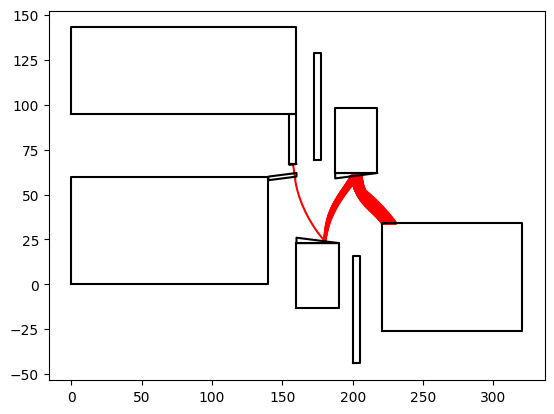

In [18]:
traj(bias, pos0_part1, time_arr, dt, dxdy_vec, vel0_part1, objects, part_share_arr, particle_counter, energies, elements_index_without_computing)
show_figure(part_share_arr)
union_obj(objects)
plt.show()

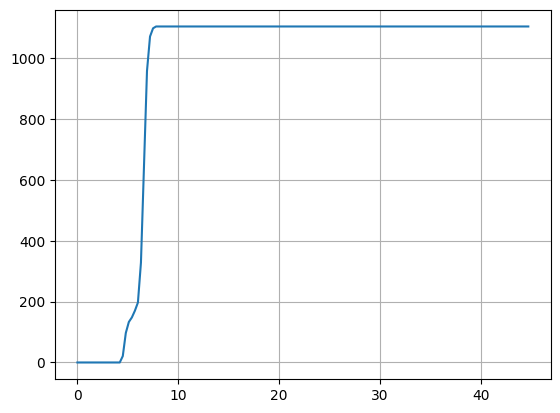

In [19]:
plt.grid()
particle_counter_sum = []
for i, _ in enumerate(particle_counter):
    particle_counter_sum.append(sum(particle_counter[:(i + 1)]))
plt.plot(time_arr * 1e12, particle_counter_sum)